<a href="https://colab.research.google.com/github/37stu37/GNS_GAN/blob/master/ctgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**import**
---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# import pandas as pd
from pathlib import Path

In [0]:
outputDir = Path('/content/drive/My Drive/Colab Notebooks/02_output/ctgan')

In [0]:
data = pd.read_parquet(outputDir / 'smallMonteCarlo2500runs.parquet')

**Data processing**
---



In [0]:
data.reset_index(inplace=True)
data.drop(['index', 'scenario', 'pid'], axis=1, inplace=True)

In [7]:
len(data) #; data.columns

7864124

In [0]:
trainingSample = data.sample(n=70000)
discrete_columns = ['source', 'target']

In [9]:
trainingSample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 2235019 to 4295981
Data columns (total 5 columns):
source        70000 non-null int64
target        70000 non-null int64
distance      70000 non-null float64
bearing       70000 non-null float64
IgnProb_bl    70000 non-null float64
dtypes: float64(3), int64(2)
memory usage: 3.2 MB


**CTGAN**

In [0]:
%%capture
!pip install ctgan 

In [0]:
%%time
from ctgan import CTGANSynthesizer

e = 85
ctgan = CTGANSynthesizer()
ctgan.fit(trainingSample, discrete_columns, epochs=e)

**save ML model**

In [0]:
MLpath = outputDir / 'ctganOutput' / f'ctganTabular_{e}epochs.pt'
# torch.save(ctgan, path)
torch.save(ctgan.state_dict(), MLpath)

# and to reload it 
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()

**Generate synthetic data**

In [0]:
!pip show pandas

In [0]:
!pip install pandas==1.0.4

In [0]:
%%time
s = 100000
for v in range(700):
  print(v)
  samples = ctgan.sample(s)
  samples.to_parquet(outputDir / 'ctganOutput' / f'smallSyntheticCTGAN{s}samplesVersion{v}.parquet', engine='pyarrow')

# **Data validation**

**importing**
---



In [49]:
%%time
%%capture
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal
# Install rtree - Geopandas requirment
!apt install python3-rtree
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes
!pip install memory_profiler

CPU times: user 304 ms, sys: 266 ms, total: 570 ms
Wall time: 1min 38s


In [103]:
import glob
import os
import dask
import dask.dataframe as dd
from dask.distributed import Client
import memory_profiler
%load_ext memory_profiler
from sys import getsizeof
import matplotlib.pyplot as plt

%matplotlib inline


from shapely.geometry import box
import geopandas as gpd

pathCTGANoutput = outputDir / 'ctganOutput'
pathShapefile = '/content/drive/My Drive/Colab Notebooks/01_githubRepo/FFE/data/shapefile'

@dask.delayed
def read_and_concatenate_parquets(prefix, path=pathCTGANoutput):
  L = []
  files = glob.glob(os.path.join(path, prefix))# output_scenario_0_step_0.parquet
  for file in files:
    print("file loaded : {}".format(file))
    pqt = dd.read_parquet(file)
    L.append(pqt)
  df = dd.concat(L)
  return df


def count_fid_occurences(df):
  count = df['source'].value_counts().compute()
  count_df = pd.DataFrame({'source': count.index, 'count': count.values})
  count_df["count"] = pd.to_numeric(count_df["count"])
  return count_df


def load_shapefile(file_name, minx, miny, maxx, maxy, path=pathShapefile):
    # crop data
    bbox = box(minx, miny, maxx, maxy)
    # building point dataset
    gdf_buildings = gpd.read_file(os.path.join(path,file_name), bbox=bbox)
    max_extent = gdf_buildings.total_bounds
    data_size = getsizeof(gdf_buildings) /(1024.0**3)
    print("Shapefile extent : {}".format(max_extent))
    print("Asset loaded : {}".format(len(gdf_buildings)))
    return gdf_buildings


def merge_coordinates_export_shape(ddf, gdf, name_output, path=pathCTGANoutput):
  gdf = gdf[['TARGET_FID', 'geometry']]
  df = pd.DataFrame(gdf)
  # ddf = ddf.compute()
  df_merge = ddf.merge(df, how='left', left_on='source', right_on='TARGET_FID')
  gdf_merge = gpd.GeoDataFrame(df_merge, geometry='geometry')
  gdf_merge.to_file(os.path.join(path, name_output + ".shp"))
  return gdf_merge

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


**runs and shapefile creation**
---



In [0]:
%%time
%%memit
ddf = read_and_concatenate_parquets("smallSyntheticCTGAN*")
count_df = count_fid_occurences(ddf)

In [64]:
count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1579 entries, 0 to 1578
Data columns (total 2 columns):
source    1579 non-null float64
count     1579 non-null int64
dtypes: float64(1), int64(1)
memory usage: 24.8 KB


In [83]:
gdfCBD = load_shapefile("buildings_raw.shp", 1748570, 5425500, 1749500, 5427600) # small
gdfRegion = load_shapefile("buildings_raw.shp", 1740508, 5420049, 1755776, 5443033) # whole

Shapefile extent : [1748498.0152998  5425264.79535007 1749563.95249987 5427653.74945021]
Asset loaded : 1611
Shapefile extent : [1740507.1581502  5420048.34765005 1755776.95354986 5443033.48509979]
Asset loaded : 74245


**Validation**
---



Create plot for CBD


*   Left - CBD, Monte Carlo 7M rows
*   Right - CBD, CTGAN 7M rows from CBD 70000 rows, 85 epochs



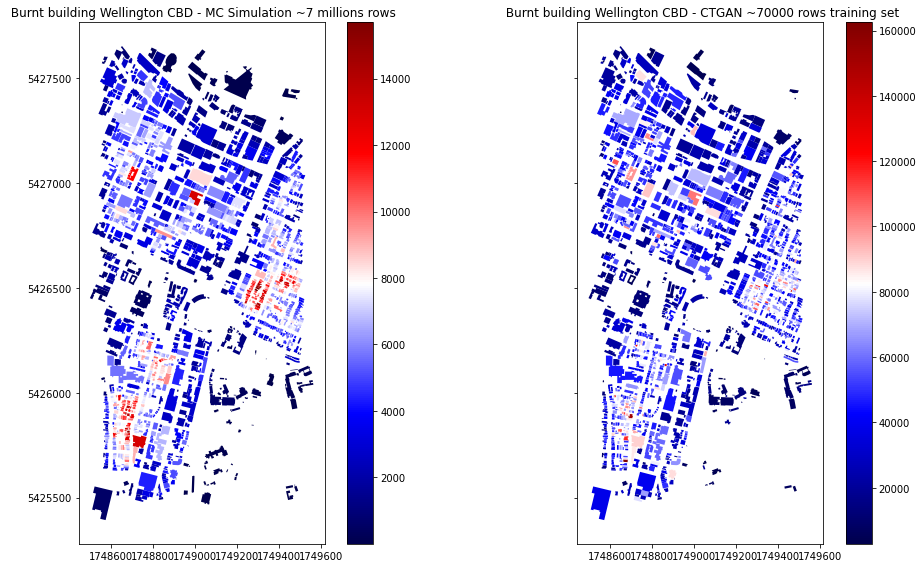

In [124]:
CBD_MonteCarloSim = gpd.read_file(outputDir / 'smallBurnedBuildings.shp')
CBD_MonteCarloSim["count"] = pd.to_numeric(CBD_MonteCarloSim["count"])
CBD_CTGAN = merge_coordinates_export_shape(count_df, gdfCBD, "CBD_SyntheticCTGANmapBurnedBuildings")
# plot
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(14, 8))
CBD_MonteCarloSim.plot(ax=ax1, column='count', cmap='seismic', legend=True, )
CBD_CTGAN.plot(ax=ax2, column='count', cmap='seismic', legend=True)
ax1.set_title(' Burnt building Wellington CBD - MC Simulation ~7 millions rows')
ax1.ticklabel_format(useOffset=False, style='plain')
ax2.set_title(' Burnt building Wellington CBD - CTGAN ~70000 rows training set')
ax2.ticklabel_format(useOffset=False, style='plain')
plt.tight_layout()
fig.savefig(pathCTGANoutput / 'comparisonCBD.jpg', dpi=300)

Create plot for Wellington region


*   Left - Wellington region, Monte Carlo 500M rows
*   Right - Wellington region, CTGAN 7M rows from CBD 70000 rows



In [0]:
# region_MonteCarloSim = gpd.read_file('/content/drive/My Drive/04_Cloud/01_Work/GNS/008_FFE/runs/results/burned_buildings.shp')
# region_MonteCarloSim["count"] = pd.to_numeric(region_MonteCarloSim["count"])
# region_CTGAN = merge_coordinates_export_shape(count_df, gdfRegion, "Regional_SyntheticCTGANmapBurnedBuildings")
# # plot
# fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(14, 8))
# region_MonteCarloSim.plot(ax=ax1, column='count', cmap='seismic', legend=True, )
# region_CTGAN.plot(ax=ax2, column='count', cmap='seismic', legend=True)
# ax1.set_title(' Burnt building Wellington Region - MC Simulation ~530 millions rows')
# ax1.ticklabel_format(useOffset=False, style='plain')
# ax2.set_title(' Burnt building Wellington Region - CTGAN ~70000 rows training set')
# ax2.ticklabel_format(useOffset=False, style='plain')
# plt.tight_layout()
# fig.savefig(pathCTGANoutput / 'comparisonRegion.jpg', dpi=300)